# Customer Churn Prediction using Artificial Neural Networks

## 1. Project Imports

In [2]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve
)

# Neural Network (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Input

## 2. Data Loading and Initial Exploration

The Banking Churn dataset contains customer demographic and account-related information.
The objective is to predict whether a customer will exit the bank using a supervised
learning approach with an Artificial Neural Network.

In [3]:
# Load the dataset
df = pd.read_csv("https://media.githubusercontent.com/media/gperdrizet/FSA_devops/refs/heads/main/data/unit4/Churn_Modeling.csv")

# Display the first few rows
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.shape

(10000, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Geography & Gender are categorical 

In [6]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No Nan's in dataset

The columns `RowNumber`, `CustomerId`, and `Surname` are identifiers and do not
contain predictive information. These columns are removed prior to modeling.

In [7]:
# Drop identifier columns
df_clean = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

In [8]:
# Churn distribution
churn_distribution = df_clean["Exited"].value_counts(normalize=True)
churn_distribution

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

The target variable shows a class imbalance, with a majority of customers
remaining with the bank and a smaller portion churning. This imbalance is
important to consider when evaluating model performance.

## 3. Data Preprocessing

Before training the neural network, the dataset is prepared by separating the
target variable from the input features and applying appropriate preprocessing
steps.

In [9]:
# Separate features and target
X = df_clean.drop(columns=["Exited"])
y = df_clean["Exited"]

In [10]:
# Look closer at categorical and numerical columns
categorical_features = ["Geography", "Gender"]
numerical_features = [col for col in X.columns if col not in categorical_features]

categorical_features, numerical_features

(['Geography', 'Gender'],
 ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'])

In [11]:
X["Gender"].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features)
    ]
)


In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [14]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed.shape, X_test_processed.shape

((8000, 11), (2000, 11))

A preprocessing pipeline was implemented using a ColumnTransformer to apply
scaling to numerical features and one-hot encoding to categorical features,
ensuring consistent and leak-free transformations.

## 4. Neural Network Model Design

In [15]:


model = Sequential([
    Input(shape=(X_train_processed.shape[1],)),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [16]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337 (1.32 KB)

 Trainable params: 337 (1.32 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training


In [18]:
history = model.fit(
    X_train_processed,
    y_train,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30


I0000 00:00:1769485875.754642   27827 service.cc:145] XLA service 0x7f1440008bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769485875.754820   27827 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 1000 Ada Generation Laptop GPU, Compute Capability 8.9


 21/250 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5340 - loss: 0.7458

I0000 00:00:1769485877.543407   27827 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7045 - loss: 0.5804
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8184 - loss: 0.4250
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8290 - loss: 0.4072
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8386 - loss: 0.3882
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8451 - loss: 0.3768
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8560 - loss: 0.3633
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8600 - loss: 0.3481
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8521 - loss: 0.3580
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8578 - loss: 0.3428
Epoch 10/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8613 - loss: 0.3331
Epoch 11/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8591 - loss: 0.3376
Epoch 12/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy

## 6. Model Evaluation


### Generate Predictions on the Test Set

In [19]:
# Predict probabilities
y_pred_prob = model.predict(X_test_processed).ravel()

# Convert probabilities to class labels (threshold = 0.5)
y_pred = (y_pred_prob >= 0.5).astype(int)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


### Confusion Matrix
The confusion matrix summarizes the model’s predictions by comparing predicted
labels with actual outcomes, highlighting true positives, false positives,
true negatives, and false negatives.

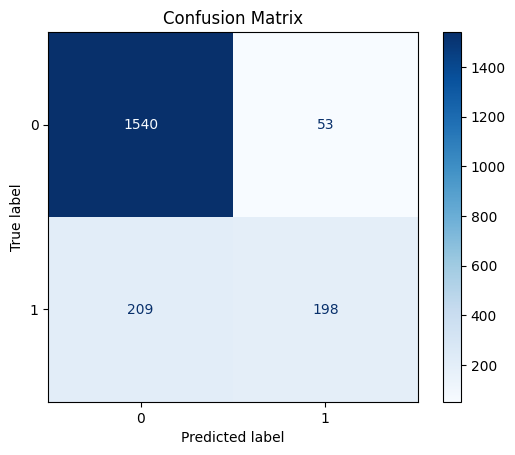

In [20]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

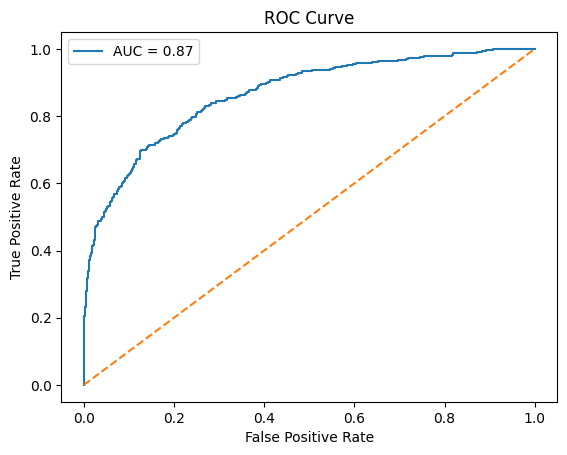

In [21]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

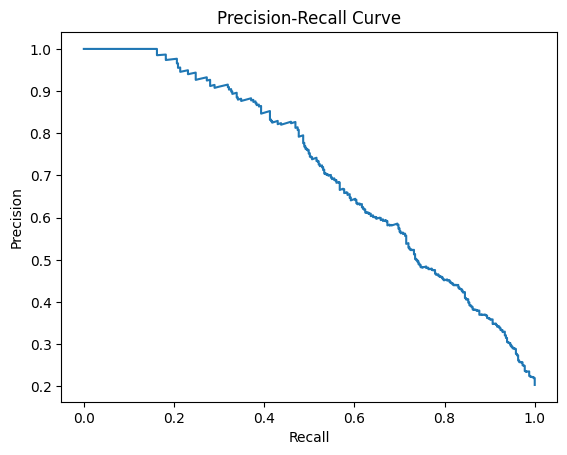

In [22]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

The confusion matrix shows that the model performs well at identifying customers
who do not churn/leave, but it misses a portion of churned customers. There are naturally many more non-churners than churners so this reflects the class imbalance in the dataset and highlights the tradeoff between precision and recall when using a fixed classification threshold.

The ROC–AUC score of approximately 0.86 indicates that the model is effective at distinguishing between churned and non-churned customers across thresholds. The precision–recall curve further illustrates the challenge of achieving high recall without sacrificing precision in an imbalanced classification problem.

## 7. Conclusions and Learnings

In this project, an Artificial Neural Network was developed to predict customer
churn using a banking dataset. Through this process, I learned how neural
networks can be applied to structured, tabular data when appropriate
preprocessing steps are taken. Encoding categorical variables and scaling
numerical features proved to be essential for effective model training. The
project reinforced the importance of building a clean and reproducible data
preprocessing pipeline to prevent data leakage and ensure consistent results.

Evaluating the model highlighted important tradeoffs inherent in imbalanced
classification problems such as churn prediction. While the model demonstrated
strong overall discrimination ability as reflected by the ROC–AUC score, the
confusion matrix and precision–recall curve showed that identifying churned
customers comes at the cost of increased false positives or missed churners
depending on the chosen threshold. This emphasized that model performance must
be interpreted in the context of business goals. Overall, this project deepened
my understanding of neural network design, evaluation metrics, and the practical
considerations involved in deploying predictive models for real-world decision
making.

## 8. Optional: Hyperparameter Tuning with KerasTuner

As an optional extension, hyperparameter tuning was explored using KerasTuner
to examine how architectural choices impact model performance. This exploration
was conducted to reinforce concepts related to model capacity and optimization.

In [23]:
def build_model(hp):
    model = Sequential()
    
    # Tune number of units in first hidden layer
    units1 = hp.Int("units_1", min_value=8, max_value=32, step=8)
    model.add(Dense(units1, activation="relu", input_shape=(X_train_processed.shape[1],)))
    
    # Tune number of units in second hidden layer
    units2 = hp.Int("units_2", min_value=4, max_value=16, step=4)
    model.add(Dense(units2, activation="relu"))
    
    model.add(Dense(1, activation="sigmoid"))
    
    # Tune learning rate
    lr = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    return model


In [24]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="kt_dir",
    project_name="churn_tuning"
)


Reloading Tuner from kt_dir/churn_tuning/tuner0.json


In [25]:
tuner.search(
    X_train_processed,
    y_train,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

In [26]:
tuner.results_summary()

Results summary
Results in kt_dir/churn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
units_1: 8
units_2: 8
learning_rate: 0.01
Score: 0.8787500262260437

Trial 1 summary
Hyperparameters:
units_1: 8
units_2: 12
learning_rate: 0.001
Score: 0.871874988079071

Trial 0 summary
Hyperparameters:
units_1: 24
units_2: 4
learning_rate: 0.001
Score: 0.8706250190734863

Trial 2 summary
Hyperparameters:
units_1: 8
units_2: 12
learning_rate: 0.0001
Score: 0.8349999785423279

Trial 3 summary
Hyperparameters:
units_1: 24
units_2: 4
learning_rate: 0.01
Score: 0.800000011920929


In [27]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'units_1': 8, 'units_2': 8, 'learning_rate': 0.01}

The hyperparameter tuning results showed that smaller network architectures with
moderate learning rates achieved the best validation performance. Increasing the
number of neurons beyond this point did not consistently improve results,
highlighting the importance of balancing model complexity and generalization.
These findings were consistent with the baseline model architecture selected
earlier in the project.

In [28]:
tuned_model = Sequential([
    Dense(8, activation="relu", input_shape=(X_train_processed.shape[1],)),
    Dense(8, activation="relu"),
    Dense(1, activation="sigmoid")
])

tuned_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train the tuned model
tuned_history = tuned_model.fit(
    X_train_processed,
    y_train,
    epochs=30,
    batch_size=32,
    verbose=1
)

# Generate predictions on the test set
tuned_y_prob = tuned_model.predict(X_test_processed).ravel()
tuned_y_pred = (tuned_y_prob >= 0.5).astype(int)

# Quick sanity check
tuned_model.evaluate(X_test_processed, y_test, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8036 - loss: 0.4629
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8465 - loss: 0.3653
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8572 - loss: 0.3513
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8634 - loss: 0.3388
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8628 - loss: 0.3368
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8680 - loss: 0.3339
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8571 - loss: 0.3495
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8586 - loss: 0.3456
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8584 - loss: 0.3473
Epoch 10/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8648 - loss: 0.3293
Epoch 11/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8609 - loss: 0.3398
Epoch 12/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

[0.34357360005378723, 0.8604999780654907]

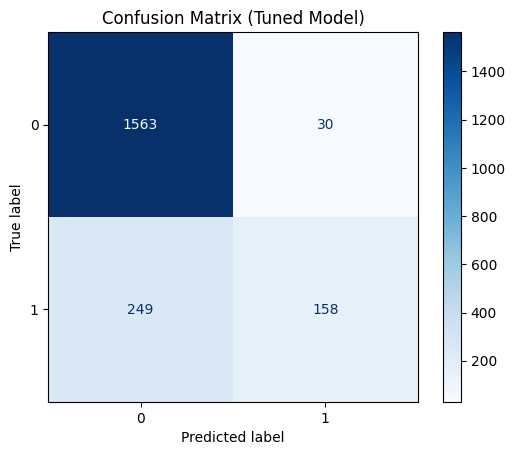

In [29]:
# Confusion Matrix for Tuned Model
cm_tuned = confusion_matrix(y_test, tuned_y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_tuned)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Tuned Model)")
plt.show()


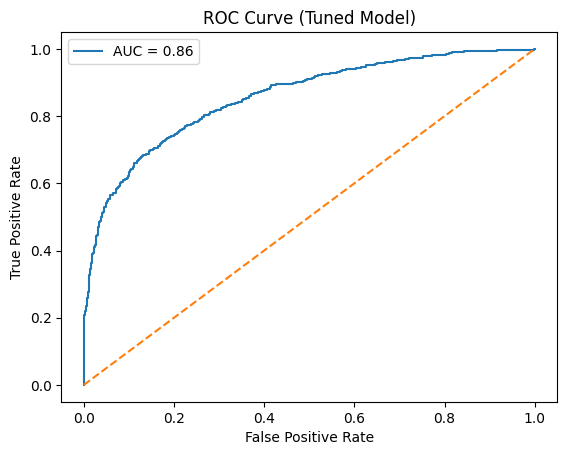

In [30]:
# ROC Curve for Tuned Model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, tuned_y_prob)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

plt.figure()
plt.plot(fpr_tuned, tpr_tuned, label=f"AUC = {roc_auc_tuned:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned Model)")
plt.legend()
plt.show()


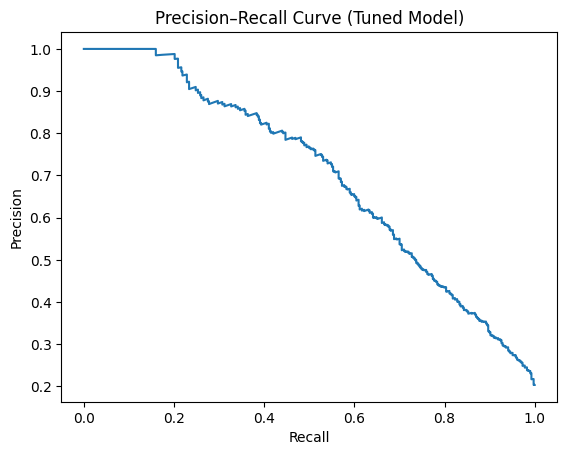

In [31]:
# Precision-Recall Curve for Tuned Model
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, tuned_y_prob)

plt.figure()
plt.plot(recall_tuned, precision_tuned)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Tuned Model)")
plt.show()


Repeating the evaluation process using a tuned neural network revealed that the
overall performance characteristics remained largely consistent with the
baseline model. While small shifts were observed in the confusion matrix, the
ROC–AUC score remained approximately the same, indicating similar discriminative
ability. The precision–recall curves also exhibited comparable shapes, reinforcing
that class imbalance continues to drive the primary tradeoffs in churn
prediction. This exercise demonstrated that hyperparameter tuning can adjust
model behavior but does not fundamentally change the underlying challenges.